In [10]:
import yfinance as yf
import pandas as pd
import talib  # Technical analysis library
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import datetime

def fetch_stock_data(symbol, start, end):
    """Fetch historical stock data for a given symbol."""
    try:
        stock = yf.Ticker(symbol.upper())  # Ensure symbol is uppercase
        data = stock.history(start=start, end=end)
        if data.empty:
            print(f"No data found for {symbol}. Please check the symbol and date range.")
            return None
        data['symbol'] = symbol
        return data
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None

def calculate_mean_reversion_indicators(data, rsi_period=14):
    """Calculate RSI and Bollinger Bands for the given data."""
    data['RSI'] = talib.RSI(data['Close'], timeperiod=rsi_period)
    data['Upper_BB'], data['Middle_BB'], data['Lower_BB'] = talib.BBANDS(
        data['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0
    )
    return data

def identify_rsi_trends(data):
    """Identify periods of RSI trends and annotate them for visualization."""
    trend_periods = []
    current_trend = None

    for i in range(1, len(data)):
        if data['RSI'].iloc[i] > 50 and (current_trend is None or current_trend != 'uptrend'):
            if current_trend is not None:
                trend_periods.append((trend_start, data.index[i - 1], current_trend))
            current_trend = 'uptrend'
            trend_start = data.index[i]
        elif data['RSI'].iloc[i] < 50 and (current_trend is None or current_trend != 'downtrend'):
            if current_trend is not None:
                trend_periods.append((trend_start, data.index[i - 1], current_trend))
            current_trend = 'downtrend'
            trend_start = data.index[i]

    if current_trend is not None:
        trend_periods.append((trend_start, data.index[-1], current_trend))

    return trend_periods

def analyze_single_stock(symbol, start_date, end_date, rsi_period=14):
    """Analyze a single stock for RSI and Bollinger Bands and return the results."""
    data = fetch_stock_data(symbol, start_date, end_date)
    if data is None:
        return None

    # Calculate the indicators
    data = calculate_mean_reversion_indicators(data, rsi_period=rsi_period)

    # Get the latest RSI value
    latest_rsi = data['RSI'].iloc[-1] if not data['RSI'].isnull().all() else None

    if latest_rsi is not None:
        stock_info = {
            'symbol': symbol,
            'RSI': latest_rsi,
            'data': data,  # Include stock data for further analysis or charting
            'rsi_trends': identify_rsi_trends(data)  # Identify RSI trends
        }
        return stock_info
    else:
        print(f"RSI could not be calculated for {symbol}.")
        return None

def plot_mean_reversion(data, symbol, rsi_trends):
    """Plot Mean Reversion signals including RSI and Bollinger Bands."""
    fig, ax = plt.subplots(3, figsize=(12, 10), sharex=True)

    # Plot the Close Price and Bollinger Bands
    ax[0].plot(data.index, data['Close'], label='Close Price', color='blue', linewidth=2)
    ax[0].plot(data.index, data['Upper_BB'], label='Upper Bollinger Band', color='red', linestyle='--', alpha=0.7)
    ax[0].plot(data.index, data['Middle_BB'], label='Middle Bollinger Band', color='gray', linestyle='--', alpha=0.7)
    ax[0].plot(data.index, data['Lower_BB'], label='Lower Bollinger Band', color='green', linestyle='--', alpha=0.7)

    # Mark strong buy/sell signals with enhanced visibility
    strong_buy_dates = data[(data['Close'] < data['Lower_BB']) & (data['RSI'] < 30)].index
    strong_sell_dates = data[(data['Close'] > data['Upper_BB']) & (data['RSI'] > 70)].index
    ax[0].scatter(strong_buy_dates, data.loc[strong_buy_dates]['Close'], color='green', edgecolor='black', marker='^', s=120, label='Strong Buy', zorder=5, alpha=0.9)
    ax[0].scatter(strong_sell_dates, data.loc[strong_sell_dates]['Close'], color='red', edgecolor='black', marker='v', s=120, label='Strong Sell', zorder=5, alpha=0.9)

    ax[0].set_ylabel('Price (USD)')
    ax[0].legend(loc='upper left')
    ax[0].set_title(f'{symbol} - Bollinger Bands')

    # Plot RSI
    ax[1].plot(data.index, data['RSI'], label='RSI', color='black', linewidth=1)
    ax[1].axhline(70, color='darkred', linestyle='--', label='Overbought (RSI 70)')
    ax[1].axhline(30, color='darkgreen', linestyle='--', label='Oversold (RSI 30)')

    # Plot RSI trend periods as vertical bars with brighter, more distinguishable colors
    for start, end, trend in rsi_trends:
        color = '#87CEFA' if trend == 'uptrend' else '#FF6347'  # Lighter blue for uptrend, lighter red for downtrend
        ax[1].axvspan(start, end, color=color, alpha=0.5, label=f'{trend.capitalize()} Period')

    ax[1].set_ylabel('RSI')
    ax[1].set_title(f'{symbol} - RSI')

    # Clean up the legend to avoid duplicate entries
    handles, labels = ax[1].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax[1].legend(by_label.values(), by_label.keys(), loc='upper left')

    # Mark overbought and oversold conditions on the chart
    overbought_dates = data[data['RSI'] > 70].index
    oversold_dates = data[data['RSI'] < 30].index

    ax[2].bar(data.index, data['Volume'], label='Volume', color='gray', alpha=0.6)
    ax[2].scatter(overbought_dates, data.loc[overbought_dates]['Volume'], color='red', label='Overbought', s=100, zorder=5)
    ax[2].scatter(oversold_dates, data.loc[oversold_dates]['Volume'], color='green', label='Oversold', s=100, zorder=5)

    # Highlight the highest volume days
    highest_volume = data['Volume'].nlargest(5)
    for date in highest_volume.index:
        color = 'green' if data.loc[date, 'Close'] > data.loc[date, 'Open'] else 'red'
        ax[2].scatter(date, highest_volume.loc[date], color=color, label='Highest Volume' if date == highest_volume.index[0] else '', s=150, zorder=6)

    # Highlight repeated high-volume periods
    volume_threshold = data['Volume'].quantile(0.95)  # Top 5% of volume
    high_volume_periods = data[data['Volume'] > volume_threshold].index
    for date in high_volume_periods:
        ax[2].axvline(date, color='purple', linestyle='--', alpha=0.3)

    ax[2].set_ylabel('Volume')
    ax[2].legend(loc='upper left')
    ax[2].set_title(f'{symbol} - Overbought/Oversold Signals with High Volume Highlights')

    # Format the date on x-axis
    date_form = DateFormatter("%b %Y")
    ax[2].xaxis.set_major_formatter(date_form)

    plt.tight_layout()
    plt.show()


In [13]:
# Get user input for stock symbol, start date, end date, and RSI period

symbol = "PLTR".strip()   # Other ones to try: "FENY", "HCA"
start_date = '2024-06-01'
end_date = datetime.today().strftime('%Y-%m-%d')
rsi_period = int(14)

Stock Symbol: PLTR
Latest RSI: 82.90


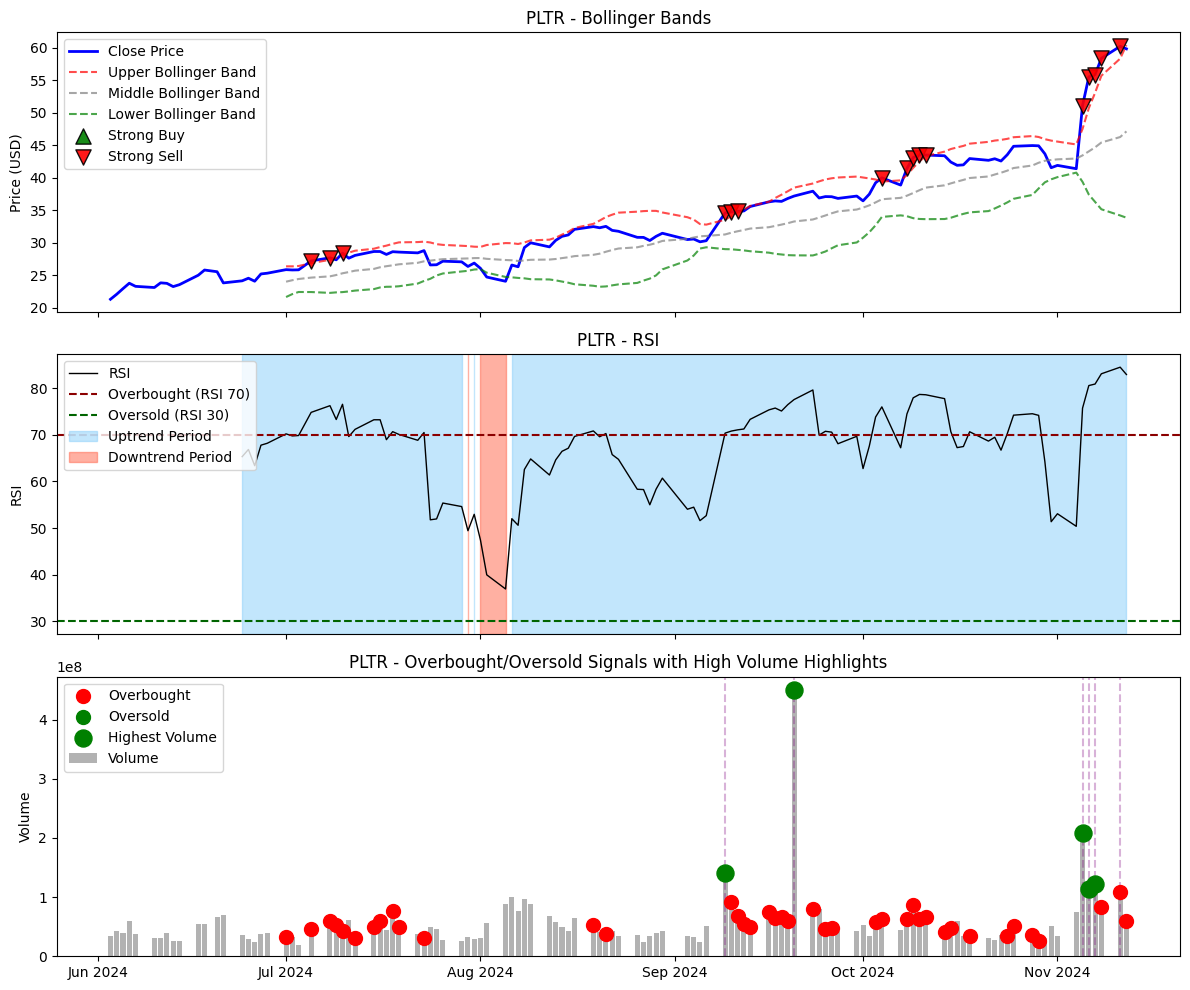

In [14]:
# Analyze the stock
stock_info = analyze_single_stock(symbol, start_date, end_date, rsi_period)

if stock_info:
    print(f"Stock Symbol: {stock_info['symbol']}")
    print(f"Latest RSI: {stock_info['RSI']:.2f}")
    plot_mean_reversion(stock_info['data'], stock_info['symbol'], stock_info['rsi_trends'])
else:
    print("Analysis could not be completed.")